In [ ]:
! pip install yfinance langchain_pinecone openai python-dotenv langchain-community sentence_transformers

In [ ]:
from langchain_pinecone import PineconeVectorStore
from openai import OpenAI
import dotenv
import json
import yfinance as yf
import concurrent.futures
from langchain_community.embeddings import HuggingFaceEmbeddings
from google.colab import userdata
from langchain.schema import Document
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone
import numpy as np
import requests
import os

In [ ]:
def get_stock_info(symbol: str) -> dict:
    """
    Retrieves and formats detailed information about a stock from Yahoo Finance.

    Args:
        symbol (str): The stock ticker symbol to look up.

    Returns:
        dict: A dictionary containing detailed stock information, including ticker, name,
              business summary, city, state, country, industry, and sector.
    """
    data = yf.Ticker(symbol)
    stock_info = data.info

    properties = {
        "Ticker": stock_info.get('symbol', 'Information not available'),
        'Name': stock_info.get('longName', 'Information not available'),
        'Business Summary': stock_info.get('longBusinessSummary'),
        'City': stock_info.get('city', 'Information not available'),
        'State': stock_info.get('state', 'Information not available'),
        'Country': stock_info.get('country', 'Information not available'),
        'Industry': stock_info.get('industry', 'Information not available'),
        'Sector': stock_info.get('sector', 'Information not available')
    }

    return properties


In [ ]:
data = yf.Ticker("NVDA")
stock_info = data.info
print(stock_info)

In [ ]:

def get_huggingface_embeddings(text, model_name="sentence-transformers/all-mpnet-base-v2"):
    """
    Generates embeddings for the given text using a specified Hugging Face model.

    Args:
        text (str): The input text to generate embeddings for.
        model_name (str): The name of the Hugging Face model to use.
                          Defaults to "sentence-transformers/all-mpnet-base-v2".

    Returns:
        np.ndarray: The generated embeddings as a NumPy array.
    """
    model = SentenceTransformer(model_name)
    return model.encode(text)


def cosine_similarity_between_sentences(sentence1, sentence2):
    """
    Calculates the cosine similarity between two sentences.

    Args:
        sentence1 (str): The first sentence for similarity comparison.
        sentence2 (str): The second sentence for similarity comparison.

    Returns:
        float: The cosine similarity score between the two sentences,
               ranging from -1 (completely opposite) to 1 (identical).

    Notes:
        Prints the similarity score to the console in a formatted string.
    """
    # Get embeddings for both sentences
    embedding1 = np.array(get_huggingface_embeddings(sentence1))
    embedding2 = np.array(get_huggingface_embeddings(sentence2))

    # Reshape embeddings for cosine_similarity function
    embedding1 = embedding1.reshape(1, -1)
    embedding2 = embedding2.reshape(1, -1)

    # Calculate cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)
    similarity_score = similarity[0][0]
    print(f"Cosine similarity between the two sentences: {similarity_score:.4f}")
    return similarity_score


# Example usage
sentence1 = "I like walking to the park"
sentence2 = "I like running to the office"

similarity = cosine_similarity_between_sentences(sentence1, sentence2)

In [ ]:
aapl_info = get_stock_info('AAPL')
print(aapl_info)

In [ ]:
aapl_description = aapl_info['Business Summary']

company_description = "I want to find companies that make smartphones and are headquarted in California"

similarity = cosine_similarity_between_sentences(aapl_description, company_description)

In [ ]:

def get_company_tickers():
    """
    Downloads and parses the Stock ticker symbols from the GitHub-hosted SEC company tickers JSON file.

    Returns:
        dict: A dictionary containing company tickers and related information.

    Notes:
        The data is sourced from the official SEC website via a GitHub repository:
        https://raw.githubusercontent.com/team-headstart/Financial-Analysis-and-Automation-with-LLMs/main/company_tickers.json
    """
    # URL to fetch the raw JSON file from GitHub
    url = "https://raw.githubusercontent.com/team-headstart/Financial-Analysis-and-Automation-with-LLMs/main/company_tickers.json"

    # Making a GET request to the URL
    response = requests.get(url)

    # Checking if the request was successful
    if response.status_code == 200:
        # Parse the JSON content directly
        company_tickers = json.loads(response.content.decode('utf-8'))

        # Optionally save the content to a local file for future use
        with open("company_tickers.json", "w", encoding="utf-8") as file:
            json.dump(company_tickers, file, indent=4)

        print("File downloaded successfully and saved as 'company_tickers.json'")
        return company_tickers
    else:
        print(f"Failed to download file. Status code: {response.status_code}")
        return None

company_tickers = get_company_tickers()

In [ ]:
company_tickers

In [ ]:
len(company_tickers)

In [ ]:
pinecone_api_key = userdata.get("PINECONE_API_KEY")
os.environ['PINECONE_API_KEY'] = pinecone_api_key

index_name = "stocks"
namespace = "stock-descriptions"

hf_embeddings = HuggingFaceEmbeddings()
vectorstore = PineconeVectorStore(index_name=index_name, embedding=hf_embeddings)

Sequential Processing since it will take lots of time to process all the stocks

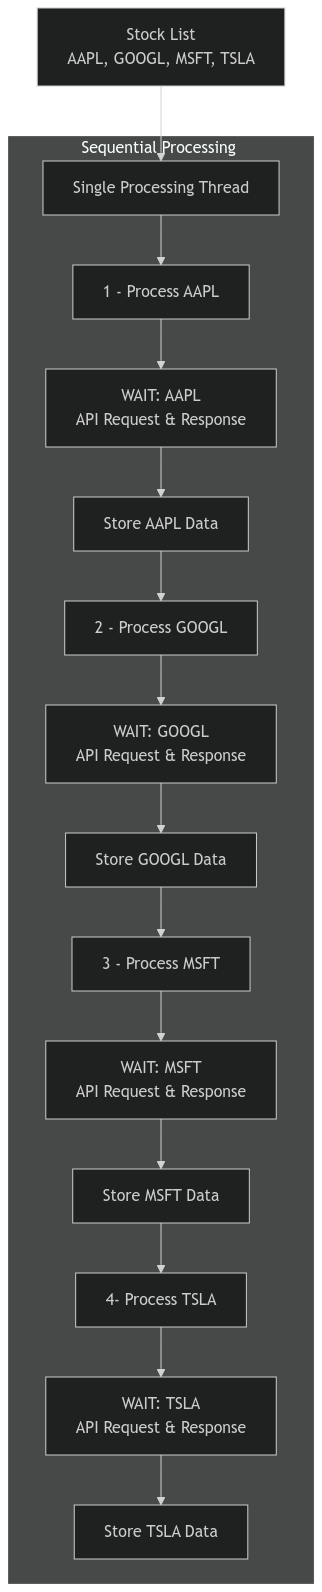

In [ ]:
for idx, stock in company_tickers.items():
    stock_ticker = stock['ticker']
    stock_data = get_stock_info(stock_ticker)
    stock_description = stock_data['Business Summary']

    print(f"Processing stock {idx} / {len(company_tickers)} :", stock_ticker)

    vectorstore_from_documents = PineconeVectorStore.from_documents(
        documents=[Document(page_content=stock_description, metadata=stock_data)],
        embedding=hf_embeddings,
        index_name=index_name,
        namespace=namespace
    )

Processing stock 0 / 9998 : NVDA
Processing stock 1 / 9998 : AAPL
Processing stock 2 / 9998 : MSFT
Processing stock 3 / 9998 : AMZN
Processing stock 4 / 9998 : GOOGL
Processing stock 5 / 9998 : META
Processing stock 6 / 9998 : TSLA
Processing stock 7 / 9998 : BRK-B
Processing stock 8 / 9998 : TSM
Processing stock 9 / 9998 : AVGO
Processing stock 10 / 9998 : LLY
Processing stock 11 / 9998 : JPM
Processing stock 12 / 9998 : WMT
Processing stock 13 / 9998 : V
Processing stock 14 / 9998 : UNH
Processing stock 15 / 9998 : SPY
Processing stock 16 / 9998 : XOM
Processing stock 17 / 9998 : ORCL
Processing stock 18 / 9998 : MA
Processing stock 19 / 9998 : NVO
Processing stock 20 / 9998 : HD
Processing stock 21 / 9998 : COST
Processing stock 22 / 9998 : PG
Processing stock 23 / 9998 : JNJ
Processing stock 24 / 9998 : BAC
Processing stock 25 / 9998 : NFLX
Processing stock 26 / 9998 : CRM
Processing stock 27 / 9998 : ABBV
Processing stock 28 / 9998 : RCIT
Processing stock 29 / 9998 : CVX
Processin

Parallelizing

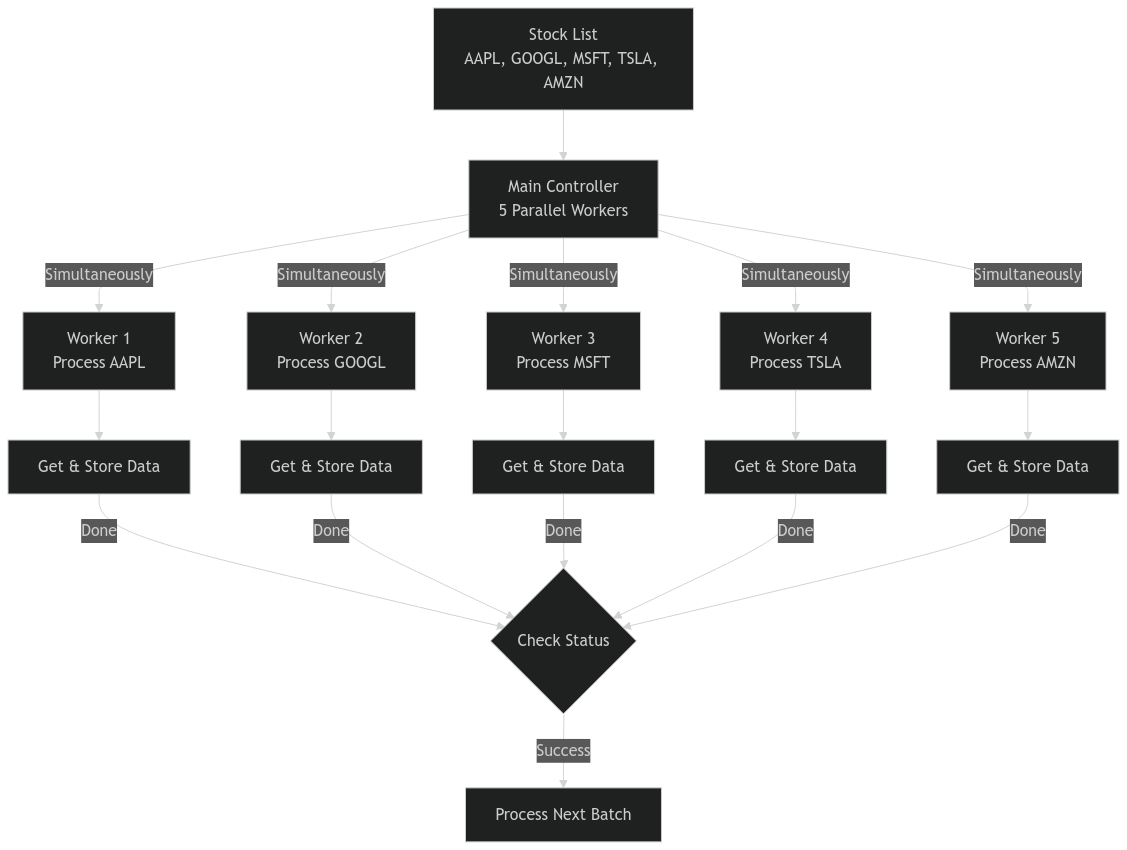

In [ ]:

successful_tickers = []
unsuccessful_tickers = []

try:
    with open('successful_tickers.txt', 'r') as f:
        successful_tickers = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(successful_tickers)} successful tickers")
except FileNotFoundError:
    print("No existing successful tickers file found")

try:
    with open('unsuccessful_tickers.txt', 'r') as f:
        unsuccessful_tickers = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(unsuccessful_tickers)} unsuccessful tickers")
except FileNotFoundError:
    print("No existing unsuccessful tickers file found")

In [ ]:
def process_stock(stock_ticker: str) -> str:
    # Skip if already processed
    if stock_ticker in successful_tickers:
        return f"Already processed {stock_ticker}"

    try:
        # Get and store stock data
        stock_data = get_stock_info(stock_ticker)
        stock_description = stock_data['Business Summary']

        # Store stock description in Pinecone
        vectorstore_from_texts = PineconeVectorStore.from_documents(
            documents=[Document(page_content=stock_description, metadata=stock_data)],
            embedding=hf_embeddings,
            index_name=index_name,
            namespace=namespace
        )

        # Track success
        with open('successful_tickers.txt', 'a') as f:
            f.write(f"{stock_ticker}\n")
        successful_tickers.append(stock_ticker)

        return f"Processed {stock_ticker} successfully"

    except Exception as e:
        # Track failure
        with open('unsuccessful_tickers.txt', 'a') as f:
            f.write(f"{stock_ticker}\n")
        unsuccessful_tickers.append(stock_ticker)

        return f"ERROR processing {stock_ticker}: {e}"

def parallel_process_stocks(tickers: list, max_workers: int = 10) -> None:
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_ticker = {
            executor.submit(process_stock, ticker): ticker
            for ticker in tickers
        }

        for future in concurrent.futures.as_completed(future_to_ticker):
            ticker = future_to_ticker[future]
            try:
                result = future.result()
                print(result)

                # Stop on error
                if result.startswith("ERROR"):
                    print(f"Stopping program due to error in {ticker}")
                    executor.shutdown(wait=False)
                    raise SystemExit(1)

            except Exception as exc:
                print(f'{ticker} generated an exception: {exc}')
                print("Stopping program due to exception")
                executor.shutdown(wait=False)
                raise SystemExit(1)

# Prepare your tickers
tickers_to_process = [company_tickers[num]['ticker'] for num in company_tickers.keys()]

# Process them
parallel_process_stocks(tickers_to_process, max_workers=10)

Processed TSM successfully
Processed GOOGL successfully
Processed META successfully
Processed AMZN successfully
Processed NVDA successfully
Processed TSLA successfully
Processed AAPL successfully
Processed AVGO successfully
Processed MSFT successfully
Processed BRK-B successfully
Processed SPY successfully
Processed XOM successfully
Processed V successfully
Processed JPM successfully
Processed UNH successfully
Processed LLY successfully
Processed WMT successfully
Processed NVO successfully
Processed ORCL successfully
Processed MA successfully
Processed HD successfully
Processed NFLX successfully
Processed RCIT successfully
Processed COST successfully
Processed CVX successfully
Processed PG successfully
Processed TMUS successfully
Processed JNJ successfully
Processed CRM successfully
Processed BAC successfully
Processed ABBV successfully
Processed SAP successfully
Processed KO successfully
Processed ASML successfully
Processed TM successfully
Processed ACN successfully
Processed WFC suc

In [ ]:
# Initialize Pinecone
pc = Pinecone(api_key=userdata.get("PINECONE_API_KEY"),)

# Connect to your Pinecone index
pinecone_index = pc.Index(index_name)


In [ ]:
query = "What are some companies that manufacture consumer hardware?"


In [ ]:
raw_query_embedding = get_huggingface_embeddings(query)

In [ ]:
top_matches = pinecone_index.query(vector=raw_query_embedding.tolist(), top_k=10, include_metadata=True, namespace=namespace)



In [ ]:
top_matches

In [ ]:


contexts = [item['metadata']['text'] for item in top_matches['matches']]

In [ ]:
augmented_query = "\n" + "\n\n-------\n\n".join(contexts[ : 10]) + "\n-------\n\n\n\n\nMY QUESTION:\n" + query

In [ ]:
print(augmented_query)

In [ ]:
client = OpenAI(
  base_url="https://api.groq.com/openai/v1",
  api_key=userdata.get("GROQ_API_KEY")
)

In [ ]:
system_prompt = f"""You are an expert at providing answers about stocks. Please answer my question provided.
"""

llm_response = client.chat.completions.create(
    model="llama-3.1-70b-versatile",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": augmented_query}
    ]
)

response = llm_response.choices[0].message.content

In [ ]:
print(response)